In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib notebook

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
dataset0 = np.load('../data/not_bright/imgs_0000.npy')
targets0 = np.load('../data/not_bright/masks_0000.npy')
dataset1 = np.load('../data/not_bright/imgs_0000.npy')
targets1 = np.load('../data/not_bright/masks_0000.npy')

dataset = np.stack((dataset0, dataset1))
targets = np.stack((targets0, targets1))

track_targets = targets.copy()
track_targets[track_targets <=0] = 0

In [12]:
X_y = train_test_split(dataset.reshape(-1, 1, 512, 512).astype(np.float32),
                       track_targets.reshape(-1, 1, 512, 512).astype(np.float32))

## load pretrained on big images network

In [6]:
network = CascadeBase(img_shape=(512, 512),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=1,
                      c_sub_objs=[1, 1, 1],
                      c_sub_obj_cs=[1e-1, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-3)

In [7]:
network.load('../weights', '3cascades_long_train')

In [8]:
import theano

In [15]:
X = X_y[1][:100]
t = X_y[-1][:100]

prediction = network.predict(X)

In [17]:
get_target = theano.function([network.targets], lasagne.layers.get_output(network.target_pool_layers[-1]))

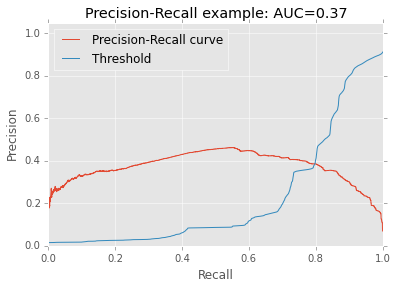

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

x_val = X_y[1][:100]
y_val = X_y[-1][:100]

prediction = network.predict(x_val)
target = get_target(y_val)

precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())
average_precision = average_precision_score(target.ravel(), prediction.ravel())

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc='best')
plt.show()

In [19]:
precision[10000]

0.11760262725779967

In [20]:
thr[10000]

0.029277153

In [21]:
recall[10000]

0.99693763919821832

In [37]:
complexity, max_complexity, miltipliers, constants = network.compute_complexity()
result = complexity[0]
max_result = max_complexity[0]

for i in range(len(complexity) - 1):
    result += complexity[i + 1] * miltipliers[i] + constants[i]
    
estimate_complexity = theano.function([network.input_X, network.targets], result / complexity[0])

In [41]:
x_val = X_y[1][:10000]
y_val = X_y[-1][:10000]

estimate_complexity(x_val, y_val) / len(x_val)

2.300544137954712

In [35]:
30448 / 283524.0

0.10739126140996882

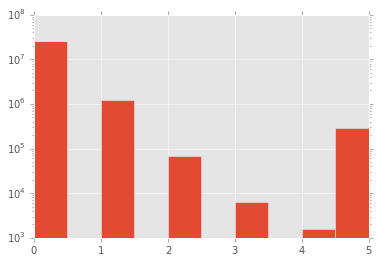

In [31]:
plt.hist(X.ravel())
plt.yscale('log')